## Notebook that compare 2 atmospheric ensity models from poliastro
- The exponential model is an approximation, which as we can observe is very far from the more complex model at altitudes around 500km (difference order of magnitude: e15)

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from astropy import units as u

from poliastro.constants import rho0_earth, H0_earth, J2000
from poliastro.earth.atmosphere import COESA76

from pyatmos import coesa76

In [4]:
# EARTH ATMOSPHERE CONSTANTS for the simple exponential atmosphere model
rho0 = rho0_earth.to(u.kg / u.km**3)  # (kg/km^3)
H0 = H0_earth.to(u.km)  # (km)

# COMPLEX ATMOSPHERIC MODEL
atmosphere_model = COESA76()

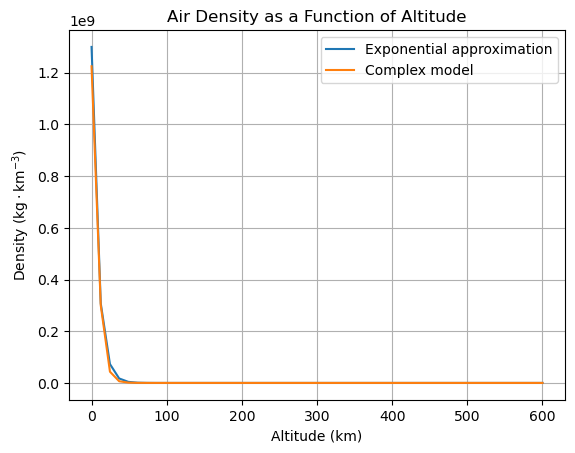

In [5]:
x = np.linspace(0, 600, 50)

y_1 = rho0.value * np.exp(-(x / H0.value))
y_2 = []
for xi in x:
    y_2.append(atmosphere_model.density(xi * u.km).to_value(u.kg / u.km**3))
y_2 = np.array(y_2)

plt.figure()
plt.title(r"Air Density as a Function of Altitude")
plt.plot(x, y_1, label="Exponential approximation")
plt.plot(x, y_2, label="Complex model")
plt.legend()
plt.xlabel(r"Altitude (km)")
# plt.ylabel(r"Density ($kg.km^(-3)$)")
plt.ylabel(r"Density ($\mathrm{kg \cdot km^{-3}}$)")
plt.grid()
plt.show()

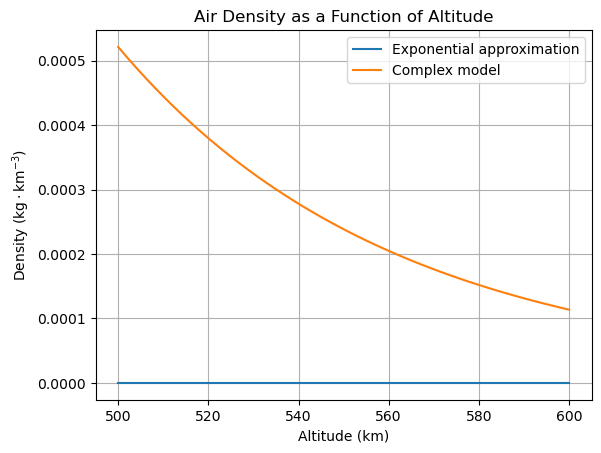

Density at 550 km (kg/m^3):  2.384562578411601e-13
Density at 550 km (kg/km^3):  0.00023845625784116008


In [ ]:
x_zoom = np.linspace(500, 600, 50)

y_1_zoom = rho0.value * np.exp(-(x_zoom / H0.value))
y_2_zoom = []
for xi in x_zoom:
    y_2_zoom.append(atmosphere_model.density(xi * u.km).to_value(u.kg / u.km**3))
y_2_zoom = np.array(y_2_zoom)

plt.figure()
plt.title(r"Air Density as a Function of Altitude")
plt.plot(x_zoom, y_1_zoom, label="Exponential approximation")
plt.plot(x_zoom, y_2_zoom, label="Complex model")
plt.legend()
plt.xlabel(r"Altitude (km)")
plt.ylabel(r"Density ($\mathrm{kg \cdot km^{-3}}$)")
plt.grid()
plt.show()

print(
    "Density at 550 km (kg/m^3): ",
    atmosphere_model.density(550 * u.km).to_value(u.kg / u.m**3),
)
print(
    "Density at 550 km (kg/km^3): ",
    atmosphere_model.density(550 * u.km).to_value(u.kg / u.km**3),
)

## Other library named ATMOS

In [ ]:
# coesa76

coesa76_geom = coesa76([550])  # geometric altitudes by default
print(coesa76_geom.rho * (u.kg / u.m**3))  # [kg/m^3]

# we observe that it gives the same results as poliastro coesa76 model => good sanity check

[2.38456258e-13] kg / m3


In [ ]:
from pyatmos import download_sw_jb2008, read_sw_jb2008
from pyatmos import jb2008

# Download or update the space weather file from https://sol.spacenvironment.net
swfile = download_sw_jb2008()
# Read the space weather data
swdata = read_sw_jb2008(swfile)
print(swdata[1])

# Set a specific time and location
t = "2014-07-22 22:18:45"  # time(UTC)
# t = '2027-07-22 22:18:45' # WILL NOT WORK! because they do not have data about the future solar activity
lat, lon, alt = 25, 102, 550  # latitude, longitude in [degree], and altitude in [km]
jb08 = jb2008(t, (lat, lon, alt), swdata)
print(jb08.rho)  # [kg/m^3]

The Space Weather files 'SOLFSMY.TXT' and 'DTCFILE.TXT' in /Users/mathildesimoni/src/sw-data/ are already the latest.
[[ 31  50  50 ...  31  31  31]
 [ 31  31  31 ...  44  44  44]
 [ 44  44  44 ...  17  31  31]
 ...
 [ 24  24  24 ...  24  24  24]
 [ 24  50  50 ...  24  50  50]
 [ 50  50  50 ... 115 115 115]]
2.966777077696953e-14


In [ ]:
from pyatmos import download_sw_nrlmsise00, read_sw_nrlmsise00

# Download or update the space weather file from www.celestrak.com
swfile = download_sw_nrlmsise00()
# Read the space weather data
swdata = read_sw_nrlmsise00(swfile)

from pyatmos import nrlmsise00

# Set a specific time and location
t = "2014-07-22 22:18:45"  # time(UTC)
lat, lon, alt = 25, 102, 600  # latitude, longitude in [degree], and altitude in [km]
nrl00 = nrlmsise00(t, (lat, lon, alt), swdata)
print(nrl00.rho)  # [kg/m^3]

1.714115212984513e-14
